## Spatial Features Vs Urban Footprint Vs Population Size

In [1]:
import sklearn
import pandas as pd
import numpy as np
import csv
import scipy.stats as stats
from statistics import pstdev
from statistics import mean
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from itertools import product
import copy
import geopandas as gpd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [2]:
np.random.seed(12345)

### Read the Features data

In [3]:
spfeas = pd.read_excel('sri_spfeas_v3.xlsx', sheet_name=0)

In [4]:
#Ensure that the GN_Code field is of type int and make it the index
spfeas['gid'] = spfeas['gid'].astype(int)
spfeas = spfeas.set_index('gid')

In [5]:
spfeas.head()

,fid,gnd_n,gnd_c,fourier_sc31_mean_mean,fourier_sc31_mean_std,fourier_sc31_mean_sum,fourier_sc31_variance_mean,fourier_sc31_variance_std,fourier_sc31_variance_sum,fourier_sc51_mean_mean,...,sfs_sc71_min_ll_sum,sfs_sc71_roa_mean,sfs_sc71_roa_std,sfs_sc71_roa_sum,sfs_sc71_std_mean,sfs_sc71_std_std,sfs_sc71_std_sum,sfs_sc71_w_mean_mean,sfs_sc71_w_mean_std,sfs_sc71_w_mean_sum
gid,,,,,,,,,,,,,,,,,,,,,
43,0,Karagaskada South,2148065,69.453586,3.136141,2.376702e+05,18.629130,0.976240,6.374888e+04,78.493900,...,3933,136.394391,0.938602,466878,16.233955,3.648450,55568.828125,1.228705,0.707158,4205.858398
564,1,Panvila,2115070,59.535572,7.845283,1.400872e+06,17.086123,2.204723,4.020365e+05,69.651317,...,40076188,137.910516,2.093903,3245724,14.498129,5.118067,341213.468750,2.838843,3.471181,66812.164062
7917,2,Ganepalla,9227135,50.730112,5.682764,3.625884e+06,14.450501,2.109653,1.032835e+06,60.710447,...,7900571136,139.556597,2.014015,9974110,9.856942,7.202832,704475.625000,3.388618,5.864246,242184.515625
2263,3,Akkaraipattu 11,5236065,73.670361,1.821871,9.731855e+04,18.843218,1.231690,2.489189e+04,82.544710,...,1331,136.077853,0.267941,180031,10.558998,4.329045,13969.554688,0.514668,0.239074,680.906372
8,4,Delgasthenna,2109125,66.878083,2.710715,2.657735e+05,18.708531,1.015577,7.434770e+04,75.957167,...,4809,136.681028,1.377590,542487,15.218429,4.465160,60401.945312,1.180995,0.868924,4687.369141


In [6]:
ghs = gpd.read_file("../../../analysis/sri_lanka/shapefiles/sri_ghs.shp")
ghs['gid'] = ghs['gid'].astype(int)
ghs = ghs.set_index('gid')
ghs.head()

,gnd_n,gnd_c,prov_c,dis_c,dsd_c,ghs_count,ghs_sum,ghs_mean,Shape_Area,geometry
gid,,,,,,,,,,
43,Karagaskada South,2148065,2,21,2148,235.0,635.0,2.702128,342335.19,"POLYGON ((80.70650072195758 7.176928435503455,..."
564,Panvila,2115070,2,21,2115,1626.0,6326.0,3.890529,2352362.54,"POLYGON ((80.73290623821237 7.36361987297315, ..."
7917,Ganepalla,9227135,9,92,9227,4929.0,6929.0,1.405762,7147144.18,"POLYGON ((80.36778185838672 7.016079031081547,..."
2263,Akkaraipattu 11,5236065,5,52,5236,89.0,5889.0,66.168539,132541.12,"POLYGON ((81.86234055205938 7.22704322335137, ..."
8,Delgasthenna,2109125,2,21,2109,274.0,2874.0,10.489051,397006.47,"POLYGON ((80.62702879794956 7.380156075748994,..."


In [7]:
ghs['PCNT_blt'] = ((ghs['ghs_sum']/101)*1444)/(ghs['Shape_Area'])*100


In [8]:
stats.describe(ghs['PCNT_blt'])

DescribeResult(nobs=14021, minmax=(0.9443431350654412, 109.87057489757564), mean=12.226958293193814, variance=557.1467539155609, skewness=2.4428853941002484, kurtosis=4.888392516975759)

In [9]:
colombo= ghs[(ghs['dis_c']==11) | (ghs['dis_c']==12)| (ghs['dis_c']==13)]
colombo.plot(column='PCNT_blt', cmap='OrRd',figsize=(10,8));

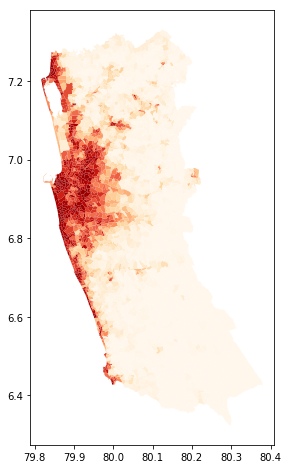

In [10]:
colombo.plot(column='PCNT_blt', cmap='OrRd',figsize=(10,8));

### Merge population data with urbanfootprint and featuures

In [11]:
ghs_cols =ghs.drop(['geometry'],axis=1)
spfeas_ghs = spfeas.merge(ghs_cols, left_on='gid', right_on="gid", how='outer')


### Analysis

In [12]:
spfeas_ghs.shape

(14021, 436)

In [13]:
#Get the list of dependent variables from the DataFrame to store in list y_vars
y_var = list(spfeas_ghs.axes[1])[435]
#Initialize a dictionary to store independent variables for each dependent variable 
y_dict = {}
#Get a list of all independent variables from the DataFrame in list all_x
all_x = list(spfeas_ghs.axes[1])[3:426]
y_var

'PCNT_blt'

Get the list of dependent variables from the DataFrame to store in list y_vars

In [14]:
#Check
# all_x

### Compute Coorelation of features with population density

Store all features with the least correlation (stat. significance (p < 0.05)) 

The Pearson correlation coefficient **measures the linear relationship
between two datasets.** Strictly speaking, Pearson's correlation requires
that each dataset be **normally distributed, and not necessarily zero-mean.**

Like other correlation coefficients, this one varies between -1 and +1
with 0 implying no correlation. Correlations of -1 or +1 imply an exact
linear relationship. Positive correlations imply that as x increases, so
does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates **the probability of an uncorrelated system**
producing datasets that have a Pearson correlation at least as extreme
as the one computed from these datasets. 

***The p-values are not entirely
reliable but are probably reasonable for datasets larger than 500 or so.***

In [15]:
spfeas_ghs[y_var] = spfeas_ghs[y_var].fillna(0)
spfeas_ghs[y_var].isnull().values.any()

False

In [16]:
y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.pearsonr(spfeas_ghs[x_var],spfeas_ghs[y_var])
    
    # print back for mike
    #print (y_var + " , " + x_var + " , " +  str(p[0]) + " , " + str(p[1]))
    
    #If p < 0.05 append to list x
    if p[1] < 0.05:
        x.append([x_var,(p[0])])

#List x is made into a DataFrame 
# which is sorted by the absolute values of the Pearson values
x_df = pd.DataFrame(x,columns=["x_var","abs_r2"]).sort_values("abs_r2",ascending=True)


#The dependent variable dictionary is given an entry 
# where the key is the name of the dependent variable
# and the value is a list of top 200 most significant values

y_dict[y_var] = list(x_df["x_var"][0:200])
#y_dict[y_var]
#Print out each dependent variable and 
#the number of x values that remain to check completion

In [17]:
x_df.head(15)

,x_var,abs_r2
172,hog_sc3_variance_std,-0.697420
166,hog_sc3_mean_std,-0.666207
416,sfs_sc71_w_mean_mean,-0.656159
183,hog_sc5_variance_mean,-0.654545
381,sfs_sc31_std_std,-0.638284
377,sfs_sc31_roa_mean,-0.636783
195,hog_sc7_variance_mean,-0.618683
308,ndvi_sc7_mean_mean,-0.604324
302,ndvi_sc5_mean_mean,-0.604140
296,ndvi_sc3_mean_mean,-0.603984


In [18]:
#check 

for key in y_dict.keys():
    print(key,len(y_dict[key]))


PCNT_blt 200


### Correlation Significance

For each dependent variable y in the list of all dependent values, calibrate the model.
Add new key to the output dictionary where y is the dependent variable curently being processed and the values are empty for now

In [19]:
#Initialize the output dictionary, Y_D, 
# with each key being a dependent variable and the values being the results of the analyses

Y_D = {}

Y_D[y_var]={}

#Dictionary Models is used to store each result object for later use if needed

Models ={}

#Get independent variables from the variable dictionary and store in list x_vars
x_vars = y_dict[y_var]


vars_df = pd.DataFrame()

vars_df[y_var] = spfeas_ghs[y_var]


for x in x_vars:
    vars_df[x] = spfeas_ghs[x]

In [20]:
vars_df.head()

,PCNT_blt,hog_sc3_variance_std,hog_sc3_mean_std,sfs_sc71_w_mean_mean,hog_sc5_variance_mean,sfs_sc31_std_std,sfs_sc31_roa_mean,hog_sc7_variance_mean,ndvi_sc7_mean_mean,ndvi_sc5_mean_mean,...,pantex_sc5_min_sum,lbpm_sc3_mean_mean,lbpm_sc7_skew_std,pantex_sc3_min_sum,sfs_sc51_roa_std,sfs_sc31_min_ll_std,sfs_sc71_min_ll_sum,sfs_sc31_min_ll_mean,orb_sc51_kurtosis_sum,sfs_sc51_min_ll_std
gid,,,,,,,,,,,,,,,,,,,,,
43,2.651966,0.025753,0.015502,1.228705,0.016466,1.750050,59.088519,0.009027,0.273208,0.369888,...,461.608368,0.444151,0.102134,72.416672,1.249185,0.038191,3933,1.001461,8.094697e+08,0.086822
564,3.844773,0.034059,0.036432,2.838843,0.025137,2.684665,59.346548,0.017032,0.290683,0.393284,...,2187.125000,0.445109,0.113695,293.166656,1.400920,0.063072,40076188,1.003994,2.263980e+09,0.084929
7917,1.386066,0.039382,0.050408,3.388618,0.030212,3.383542,59.889562,0.023068,0.311947,0.422038,...,2096.283203,0.445847,0.096620,261.833344,1.047181,0.047993,7900571136,1.002309,0.000000e+00,0.062023
2263,63.523839,0.022686,0.011365,0.514668,0.015753,1.604686,57.499622,0.008823,0.160211,0.216929,...,179.112488,0.446682,0.094314,31.250000,0.599909,0.054903,1331,1.003023,0.000000e+00,0.115846
8,10.349872,0.028749,0.027216,1.180995,0.018729,1.744855,58.869489,0.010275,0.269193,0.364343,...,303.537506,0.444464,0.128454,32.166672,1.298070,0.054903,4809,1.003023,1.929741e+08,0.093491


### Scale/Normalize Data

In [21]:
minmax_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()

names = vars_df.columns
scaled_df = standard_scaler.fit_transform(vars_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.head()

,PCNT_blt,hog_sc3_variance_std,hog_sc3_mean_std,sfs_sc71_w_mean_mean,hog_sc5_variance_mean,sfs_sc31_std_std,sfs_sc31_roa_mean,hog_sc7_variance_mean,ndvi_sc7_mean_mean,ndvi_sc5_mean_mean,...,pantex_sc5_min_sum,lbpm_sc3_mean_mean,lbpm_sc7_skew_std,pantex_sc3_min_sum,sfs_sc51_roa_std,sfs_sc31_min_ll_std,sfs_sc71_min_ll_sum,sfs_sc31_min_ll_mean,orb_sc51_kurtosis_sum,sfs_sc51_min_ll_std
0,-0.405666,-1.316639,-1.438002,-1.459916,-1.481615,-1.693512,-0.384825,-1.491887,0.380898,0.384714,...,-0.232521,0.127163,0.030145,-0.234151,-0.151028,-0.146697,-0.108825,-0.104701,-0.039848,-0.081676
1,-0.355130,0.379692,0.426730,0.154198,0.342887,0.058786,-0.008228,0.370608,0.707864,0.708528,...,0.034701,0.646527,0.924699,0.073596,-0.086279,-0.146661,-0.107449,-0.104168,1.007856,-0.081682
2,-0.459299,1.466919,1.671890,0.705331,1.410625,1.369101,0.784310,1.775044,1.105743,1.106495,...,0.020632,1.046278,-0.396486,0.029914,-0.237229,-0.146683,0.162342,-0.104523,-0.622920,-0.081744
3,2.173310,-1.943017,-1.806559,-2.175716,-1.631792,-1.966053,-2.703847,-1.539475,-1.733326,-1.732327,...,-0.276269,1.499080,-0.574925,-0.291541,-0.428093,-0.146673,-0.108825,-0.104372,-0.622920,-0.081597
4,-0.079527,-0.704706,-0.394391,-1.507744,-1.005454,-1.703252,-0.704504,-1.201625,0.305774,0.307966,...,-0.257000,0.297068,2.066690,-0.290263,-0.130168,-0.146673,-0.108825,-0.104372,-0.483918,-0.081658


### Set Elastic net's parameters

In [22]:
enet_result = ElasticNetCV(max_iter=1e8,
                    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1],
                    l1_ratio =[.1, .5, .7, .9, .95, .99, 1],
                    verbose= False,
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)


In [23]:
scaled_df.shape

(14021, 201)

In [24]:
# Fit the mode

In [25]:
#Fit the model with the scaled data
X_train, X_test, y_train, y_test = train_test_split(scaled_df[x_vars],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)
#Append the model to the Models dictionary
Models[y_var] = enet_result


In [26]:
enet_result

ElasticNetCV(alphas=[0.0005, 0.001, 0.01, 0.03, 0.05, 0.1], copy_X=True, cv=5,
       eps=0.001, fit_intercept=False,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=100000000.0,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='random',
       tol=0.0001, verbose=False)

In [27]:
opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_

#Print update to ensure that the script is progressing properly
print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[x_vars],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))

R2: 0.79 Alpha: 0.0005 l1_ratio: 1.0


Record the overall R squared score and optimal alpha 
and l1 ratio values and store them in the output dictionary


In [28]:
Y_D[y_var]['Total R2'] = enet_result.score(scaled_df[x_vars],scaled_df[y_var])
Y_D[y_var]['Alpha'] = opt_alpha
Y_D[y_var]['l1_ratio'] = opt_l1_ratio

### Ten Fold Cross validated regression

In [29]:
#Create a list R2s to store out of sample R squared values

R2s = []

#Specify the number of trials to run

trials = 10

#Run the number of trials specified in trials, 
#for each trial 66% of the observations are randomly selected to train the model
#Testing is done on the remaining 33% of observations and the R squared values are recorded

for i in range(trials):    
    X_train, X_test, y_train, y_test = train_test_split(scaled_df[x_vars],scaled_df[y_var], test_size=0.34)
    enet_regr = ElasticNetCV(max_iter=1e8,
                    alphas = [opt_alpha],
                    l1_ratio =[opt_l1_ratio],
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)
    y_pred = enet_regr.fit(X_train,y_train).predict(X_test)
    RMSE = np.sqrt(mse(y_test, y_pred))
    MAE = (mae(y_test, y_pred))
    r_squared = enet_regr.score(X_test,y_test)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    R2s.append(r_squared)

#print("Mean R2: {:.2f} StDev: {:.4f}".format(mean(R2s),pstdev(R2s)))
#Record the out of sample R squared values
Y_D[y_var]["Adj_R2"] = adjusted_r_squared
Y_D[y_var]["RMSE"] = RMSE
Y_D[y_var]["MAE"] = MAE
Y_D[y_var]['Sampling']={'trials':trials,'R2':mean(R2s),'StDev':pstdev(R2s),'R2s':R2s}
#coefs = [i for i in zip(list(scaled_df[x_vars].axes[1]),enet_result.coef_)]
#remaining = [i for i in coefs if abs(i[1])>0.0]
#Y_D[y_var]["Coefficients"]=remaining

In [30]:

Y_D[y_var]

{'Total R2': 0.7910873810354917,
 'Alpha': 0.0005,
 'l1_ratio': 1.0,
 'Adj_R2': 0.7997487017399995,
 'RMSE': 0.44744884092121157,
 'MAE': 0.2709774409034015,
 'Sampling': {'trials': 10,
  'R2': 0.7899964314488906,
  'StDev': 0.012037674601385003,
  'R2s': [0.8038583079996786,
   0.7818379047315075,
   0.7970209413846663,
   0.7764231702648399,
   0.7855058186817095,
   0.8104807717636247,
   0.7849799752026243,
   0.7774337681430691,
   0.7783461327384491,
   0.8040775235787371]}}

In [31]:
y_df = pd.DataFrame([i for i in zip(list(scaled_df[x_vars].axes[1]),enet_result.coef_)], 
                    columns=["features","Coeff"]).sort_values("Coeff", ascending=False)

y_df.head(15)

,features,Coeff
20,ndvi_sc5_variance_mean,5.147064
43,lbpm_sc3_max_mean,0.564658
103,ndvi_sc7_variance_sum,0.418561
62,sfs_sc51_max_ll_sum,0.400933
161,sfs_sc31_max_ll_sum,0.307613
3,hog_sc5_variance_mean,0.285097
56,lsr_sc5_line_length_mean,0.224126
79,lbpm_sc7_kurtosis_sum,0.189953
24,lbpm_sc3_variance_std,0.173431
55,lbpm_sc5_max_std,0.163965


## HOG

In [32]:
filter_var = [col for col in scaled_df if col.startswith('hog')]
X_train, X_test, y_train, y_test = train_test_split(scaled_df[filter_var],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)

Models[y_var] = enet_result

opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_


print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[filter_var],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))


R2: 0.69 Alpha: 0.0005 l1_ratio: 1.0


## LBPM

In [33]:
filter_var = [col for col in scaled_df if col.startswith('lbpm')]
X_train, X_test, y_train, y_test = train_test_split(scaled_df[filter_var],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)

Models[y_var] = enet_result

opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_


print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[filter_var],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))


R2: 0.64 Alpha: 0.0005 l1_ratio: 0.1


## Gabor

In [34]:
filter_var = [col for col in scaled_df if col.startswith('gabor')]
X_train, X_test, y_train, y_test = train_test_split(scaled_df[filter_var],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)

Models[y_var] = enet_result

opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_


print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[filter_var],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))


R2: 0.02 Alpha: 0.0005 l1_ratio: 0.1


## Fourier

In [35]:
ilter_var = [col for col in scaled_df if col.startswith('fourier')]
X_train, X_test, y_train, y_test = train_test_split(scaled_df[filter_var],scaled_df[y_var], test_size=0.34)
enet_result.fit(X_train,y_train)

Models[y_var] = enet_result

opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_


print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[filter_var],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))


R2: 0.02 Alpha: 0.001 l1_ratio: 0.9


In [36]:
vars

<function vars>

### Scale the variables

In [37]:
predicted_blt = enet_regr.predict(spfeas[x_vars])


In [38]:
pred = pd.Series(predicted_blt)
ghs['predicted'] = pred

In [39]:
ghs.head()

,gnd_n,gnd_c,prov_c,dis_c,dsd_c,ghs_count,ghs_sum,ghs_mean,Shape_Area,geometry,PCNT_blt,predicted
gid,,,,,,,,,,,,
43,Karagaskada South,2148065,2,21,2148,235.0,635.0,2.702128,342335.19,"POLYGON ((80.70650072195758 7.176928435503455,...",2.651966,-1.281238e+09
564,Panvila,2115070,2,21,2115,1626.0,6326.0,3.890529,2352362.54,"POLYGON ((80.73290623821237 7.36361987297315, ...",3.844773,-1.815504e+09
7917,Ganepalla,9227135,9,92,9227,4929.0,6929.0,1.405762,7147144.18,"POLYGON ((80.36778185838672 7.016079031081547,...",1.386066,-6.685235e+09
2263,Akkaraipattu 11,5236065,5,52,5236,89.0,5889.0,66.168539,132541.12,"POLYGON ((81.86234055205938 7.22704322335137, ...",63.523839,-8.133768e+09
8,Delgasthenna,2109125,2,21,2109,274.0,2874.0,10.489051,397006.47,"POLYGON ((80.62702879794956 7.380156075748994,...",10.349872,-8.691500e+09


/Users/adbe/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


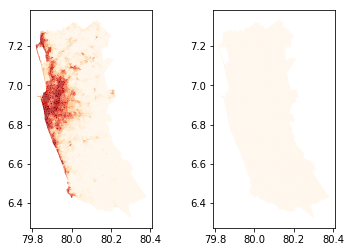

In [40]:
colombo= ghs[(ghs['dis_c']==11) | (ghs['dis_c']==12)| (ghs['dis_c']==13)]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2)

colombo.plot(column='PCNT_blt', cmap='OrRd',figsize=(10,8),ax=axes[0]);
colombo.plot(column='predicted', cmap='OrRd',figsize=(10,8),ax=axes[1]);